# Plotting PyPSA results (adapted for the First Run of Bolivia - config.yaml file)

### Adele will check for additional results that can be used


In [1]:
###### algunas cosas cambian si pongo como comentarios en el import de geoviews y hvplot (liberias conflictivas?)

import logging
import os

import pypsa

import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-earth")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

This is the repository path:  /Users/adelehannotte/Pypsa-earth/pypsa-earth
Had to go 1 folder(s) up.


In [2]:
# utility function for nice plotting

def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size/10

In [3]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
shapes=world[world.name.isin(["Bolivia"])].set_index("name")

# Load all networks

In [4]:
solved_4_network = os.getcwd() +  "/results/networks/elec_s_4_ec_lcopt_Co2L-3H.nc"

#Se cargan los resultados de la optimizacion del problema segun las caracteristicas definidas para el modelo en n_solve con la funcion (operador?) Network de pypsa

n_solve_4 = pypsa.Network(solved_4_network)

INFO:pypsa.io:Imported network elec_s_4_ec_lcopt_Co2L-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [5]:
solved_37_network = os.getcwd() +  "/results/networks/elec_s_37_ec_lcopt_Co2L-3H.nc"

#Se cargan los resultados de la optimizacion del problema segun las caracteristicas definidas para el modelo en n_solve con la funcion (operador?) Network de pypsa

n_solve_37 = pypsa.Network(solved_37_network)

#fig, ax = plt.subplots(figsize=(7, 7),subplot_kw={'projection': ccrs.PlateCarree()})

#n_solve_37.plot(ax=ax)
#ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


INFO:pypsa.io:Imported network elec_s_37_ec_lcopt_Co2L-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


# Solved network

In [6]:
n = n_solve_37

In [7]:
# ".global_constraints" muestra las restricciones consideradas para el modelo (en el config.yaml solo se tomo en cuenta el limite de emisiones) tonCO2/year

n.global_constraints

,sense,constant,mu,type,investment_period,carrier_attribute
GlobalConstraint,,,,,,
CO2Limit,<=,77500000.0,5.824219e-07,primary_energy,NaN,co2_emissions


In [8]:
#Calculation of the average price of average energy in the network (total cost of operation) = ".objective" / (sum of variable loads over time)
#[€/MWh]
#Total annual system costs in  euros per year?

n.objective

356291858.4602345

## Generators

In [9]:
n.carriers

,co2_emissions,color,nice_name,max_growth,max_relative_growth
Carrier,,,,,
geothermal,0.026,#ba91b1,Geothermal,inf,0.0
CCGT,0.187,#b20101,Combined-Cycle Gas,inf,0.0
onwind,0.000,#235ebc,Onshore Wind,inf,0.0
solar,0.000,#f9d002,Solar,inf,0.0
oil,0.248,#262626,Oil,inf,0.0
lignite,0.334,#9e5a01,Lignite,inf,0.0
nuclear,0.000,#ff9000,Nuclear,inf,0.0
OCGT,0.187,#d35050,Open-Cycle Gas,inf,0.0
biomass,0.000,#0c6013,Biomass,inf,0.0


p_nom_opt: nominal installed capacity

capital_cost: investment cost of the technology

marginal_cost: marginal cost of the technology

p_nom_extendable: (True/False) binary variable stating whether the capacity of the asset can be changed

In [56]:
# Group the dataframe by "carrier" and count the number of rows in each group
num_plants =n.generators.groupby("carrier").size()

df_gen=n.generators.groupby(["carrier"])[
    ["p_nom_opt","p_nom", "capital_cost", "marginal_cost", "p_nom_extendable"]
].agg(
    {
        "p_nom_opt": "sum",
        "p_nom": "sum",
        "capital_cost": "mean",
        "marginal_cost": "mean",
        "p_nom_extendable": "sum",
    }
)
# Add the "num_plants" series as a new column to the df_gen dataframe
df_gen["num_plants"] = num_plants

df_gen

,p_nom_opt,p_nom,capital_cost,marginal_cost,p_nom_extendable,num_plants
carrier,,,,,,
OCGT,0.0,914.340881,47234.561404,58.384615,8,8
oil,0.0,33.996513,38234.561404,130.226463,0,1
onwind,0.0,25.800649,109295.569252,0.015000,107,107
ror,0.0,344.006279,270940.715283,0.000000,0,11
solar,0.0,119.195969,50855.958267,0.010000,111,111


# Generators: total capacity

p_nom in [MW] https://pypsa.readthedocs.io/en/latest/components.html


In [11]:
gen_cap = n.generators.groupby(["carrier"]).sum()

gen_cap['p_nom']

/var/folders/n4/_tj5q4j14x1btpmbdy4tlc780000gn/T/ipykernel_6417/3310162589.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gen_cap = n.generators.groupby(["carrier"]).sum()


carrier
OCGT      9.143409e+02
load      3.700000e+10
oil       3.399651e+01
onwind    2.580065e+01
ror       3.440063e+02
solar     1.191960e+02
Name: p_nom, dtype: float64

In [12]:
# Drop the "load" row from the DataFrame
total_gen_pnom=gen_cap.drop("load").sum()['p_nom']

total_gen_pnom #MW

1437.3402905559576

Just to check if this is the same in n_elec

In [47]:
elec_network= os.getcwd() +  "/networks/elec.nc"
n_elec= pypsa.Network(elec_network)

gen_cap = n.generators.groupby(["carrier"]).sum()
gen_cap['p_nom']

total_gen_pnom=gen_cap.sum()['p_nom']

total_gen_pnom #MW

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers
/var/folders/n4/_tj5q4j14x1btpmbdy4tlc780000gn/T/ipykernel_6417/2762366959.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gen_cap = n.generators.groupby(["carrier"]).sum()


1437.3402905559576

In [51]:
n_elec

PyPSA Network 'PyPSA-Eur'
Components:
 - Bus: 131
 - Carrier: 13
 - Generator: 238
 - Line: 115
 - Load: 112
 - StorageUnit: 2
 - Transformer: 19
Snapshots: 8760

In [50]:
base_network= os.getcwd() +  "/networks/base.nc"

n_base= pypsa.Network(base_network)
n_base

INFO:pypsa.io:Imported network base.nc has buses, lines, transformers


PyPSA Network 'PyPSA-Eur'
Components:
 - Bus: 131
 - Line: 115
 - Transformer: 19
Snapshots: 8760

In [13]:
gen_cap['p_nom_opt']

carrier
OCGT      9.144259e+02
load      3.700000e+10
oil       3.399651e+01
onwind    2.590013e+01
ror       3.440063e+02
solar     2.057775e+03
Name: p_nom_opt, dtype: float64

# Renewable availability

<AxesSubplot:xlabel='snapshot'>

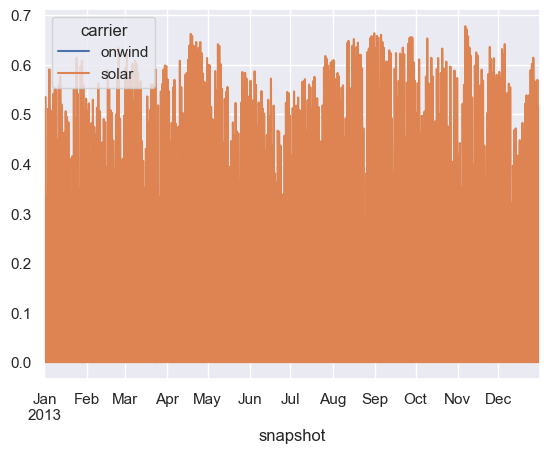

In [14]:
n.generators_t.p_max_pu.groupby(n.generators.carrier, axis=1).mean().plot()

## Timeseries datas

In [15]:
gen_tot_t=n.generators_t
gen_tot_t
#gen_34_t=gen_tot_t[gen_tot_t['bus']=='34']
#gen_tot_t.index.get_level_values('time') 
gen_tot_t.p['43 OCGT']

snapshot
2013-01-01 00:00:00    70.996030
2013-01-01 03:00:00    32.001515
2013-01-01 06:00:00    30.816280
2013-01-01 09:00:00    13.681295
2013-01-01 12:00:00    18.781927
                         ...    
2013-12-31 09:00:00    15.508987
2013-12-31 12:00:00    24.214508
2013-12-31 15:00:00     0.012691
2013-12-31 18:00:00     9.130178
2013-12-31 21:00:00    36.810960
Name: 43 OCGT, Length: 2920, dtype: float64

# Energy balance

In [16]:
# Difference between total load and generation
# losses = n.stores_t

n.generators_t.p.sum().sum() - n.loads_t.p.sum().sum()  # - substract storage losses


-24942.230837018695

In [17]:
n.loads_t.p.sum().sum()/1e6

3.7793635208145764

In [18]:
n.generators_t.p.sum().sum()/1e6

3.7544212899775573

In [19]:
n.stores_t.p.sum().sum()

1.3224352168883513e-12

In [20]:
# If 0, all renewable capacity potential is used
n.generators.p_nom_max.sum() - n.generators.p_nom_opt.sum()

inf

# How load is computed

<AxesSubplot:xlabel='snapshot'>

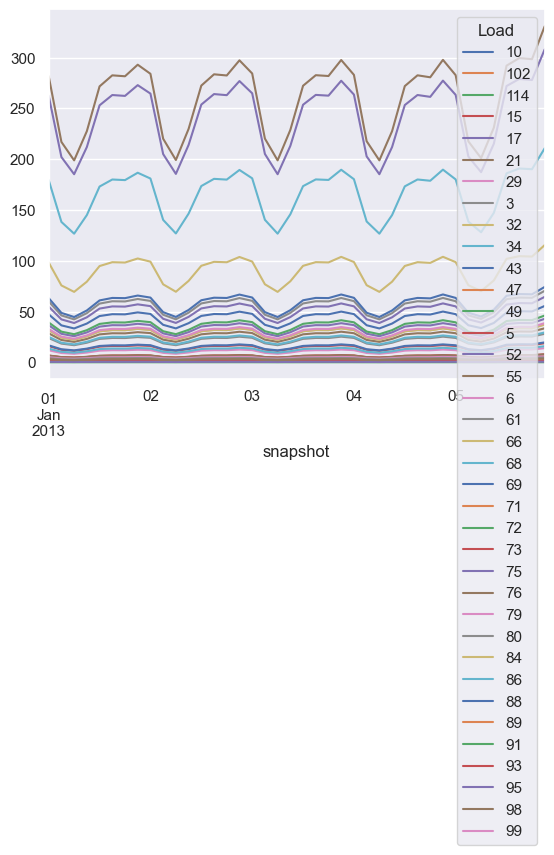

In [21]:
n.loads_t.p.loc["2013-01-01":"2013-01-05"].plot()

<AxesSubplot:xlabel='snapshot'>

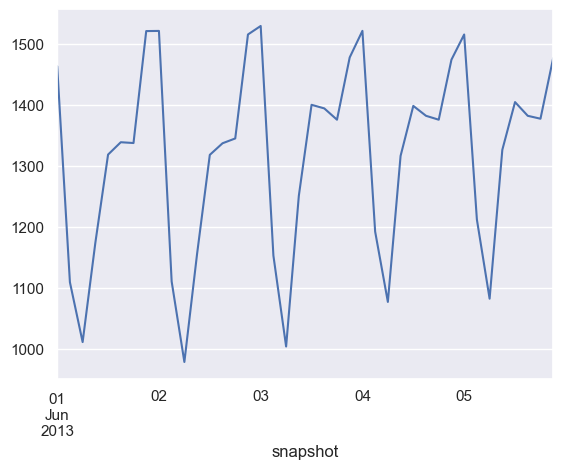

In [22]:
n.loads_t.p.loc["2013-06-01":"2013-06-05"].sum(axis=1).plot()

In [23]:
n.loads_t.p.sum(axis=1)

snapshot
2013-01-01 00:00:00    1408.615194
2013-01-01 03:00:00    1085.037258
2013-01-01 06:00:00     994.279569
2013-01-01 09:00:00    1137.929551
2013-01-01 12:00:00    1358.383295
                          ...     
2013-12-31 09:00:00    1131.251556
2013-12-31 12:00:00    1353.768356
2013-12-31 15:00:00    1406.486662
2013-12-31 18:00:00    1404.001289
2013-12-31 21:00:00    1486.321967
Length: 2920, dtype: float64

In [24]:
n.loads_t.p.sum().sum()*3/1e3 #[GWh]

11338.09056244373

<AxesSubplot:xlabel='snapshot'>

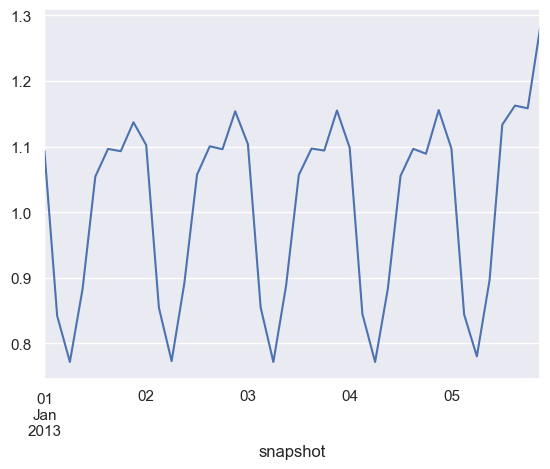

In [25]:
#n.loads_t.p_set.loc["2013-01-01":"2013-06-06","10 load"].plot()
n.loads_t.p_set.loc["2013-01-01":"2013-01-05","10"].plot()

In [26]:
type(n.loads_t.p_set.sum())

pandas.core.series.Series

# Nice graphs

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


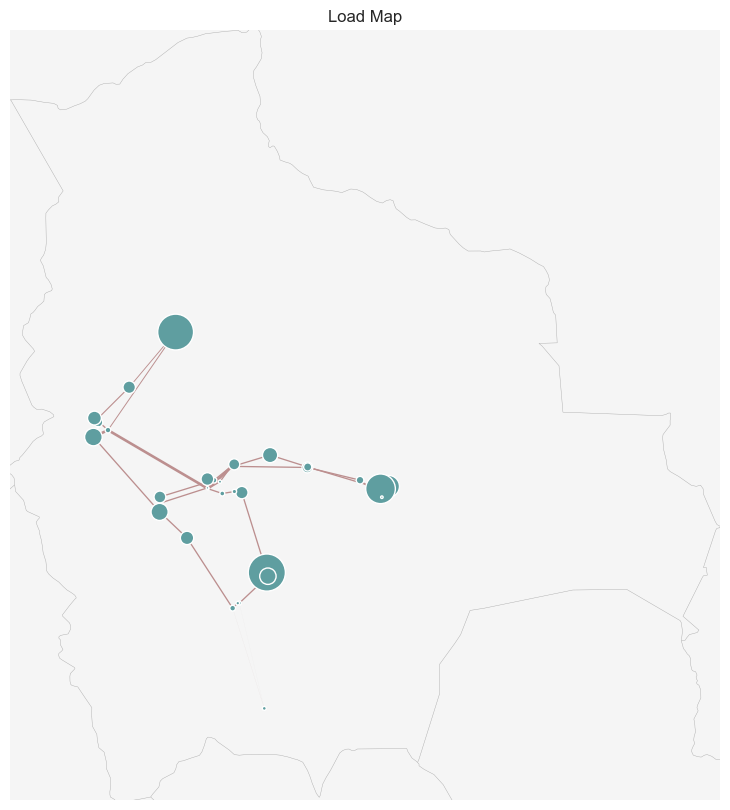

In [27]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=ax,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    ),  # n.loads_t.p_set.sum().rename("load").rename_axis("bus")*.0000003,
    bus_cmap=True,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Load Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");
ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())



In [28]:
# backup
gen_serie = n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()
load_serie = n.loads_t.p_set.sum().rename("load").rename_axis("bus")

load_serie = pd.Series(
    load_serie.values,
    index=pd.MultiIndex.from_tuples([(id, "AC load") for id in load_serie.index]),
)

tot_serie = pd.concat([gen_serie, load_serie])  # .groupby(['bus', 'carrier']).sum()

pd.concat([gen_serie, load_serie])

bus  carrier
10   load       1.000000e+09
     onwind     1.292841e-03
     solar      5.084616e-02
102  load       1.000000e+09
     onwind     6.274160e-03
                    ...     
91   AC load    1.052842e+05
93   AC load    3.499380e+03
95   AC load    1.412598e+03
98   AC load    8.449244e+03
99   AC load    8.819760e+04
Length: 159, dtype: float64

### Plot of Average Marginal Price

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


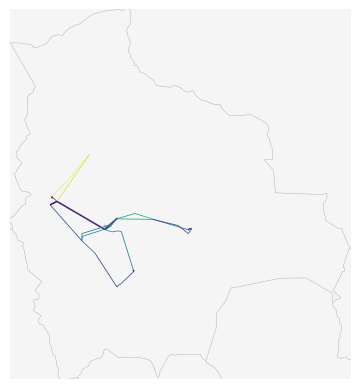

In [29]:
loading = (n.lines_t.p0.abs().mean().sort_index() / (n.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)
# Example types of projections: PlateCarree, Mercator, Orthographic
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
n.plot(ax=ax,
    bus_colors='gray',
    branch_components=["Line"],
    line_widths=n.lines.s_nom_opt/5e2,
    line_colors=loading,
    line_cmap=plt.cm.viridis,
    color_geomap=True,
    bus_sizes=0
)
ax.axis('off')
ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


### Storage

<AxesSubplot:xlabel='snapshot'>

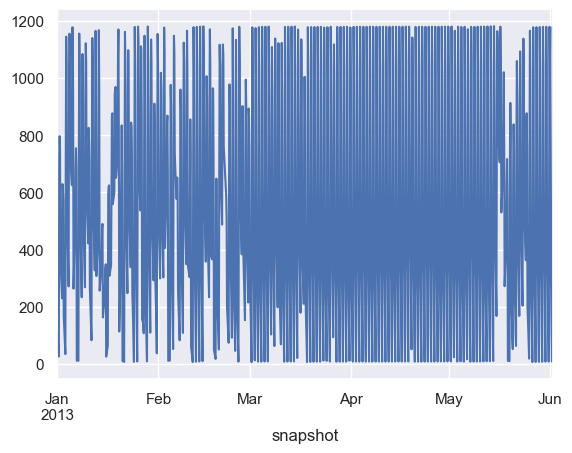

In [30]:
n.stores_t.e.loc["2013-01-01":"2013-06-01"].sum(axis=1).plot()

In [31]:
n.storage_units.groupby(by="carrier")["p_nom_opt"].sum()

carrier
hydro    53.312102
Name: p_nom_opt, dtype: float64

In [32]:
n_solve.storage_units

NameError: name 'n_solve' is not defined

In [ ]:
n.links.iloc[:].groupby(["carrier"]).p_nom_opt.sum()

# Plot hourly dispatch 

In [ ]:
gen_cap = n.generators.groupby(["carrier"]).sum()
gen_cap['p_nom']

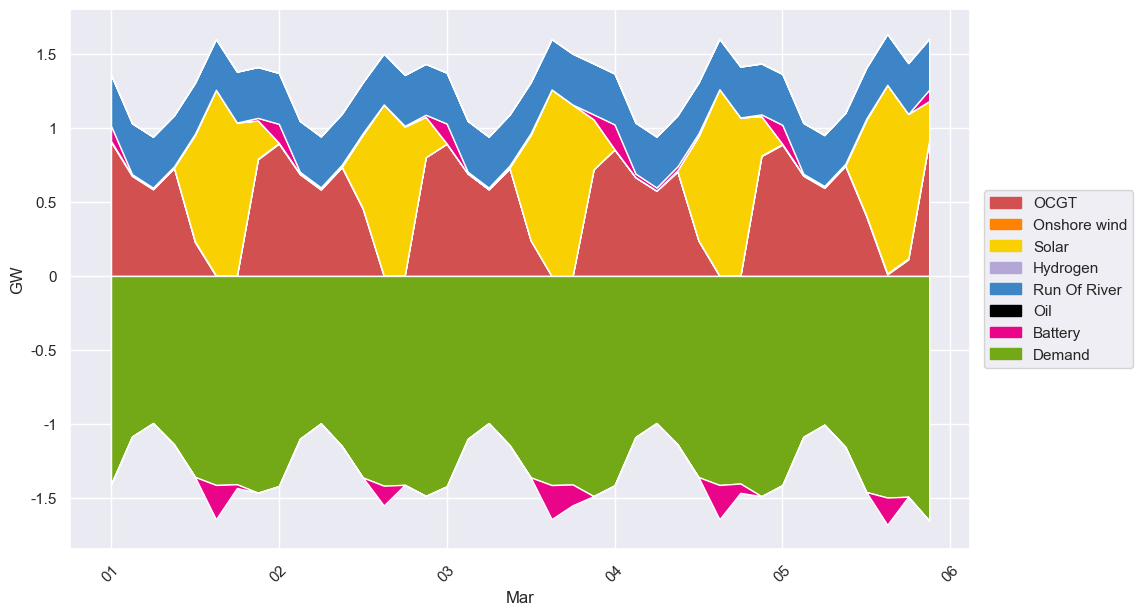

In [84]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

n = n_solve_37

first_date = "2013-01-01"
second_date = "2013-01-05"
OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
ror = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["ror"]
oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]
H2 = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["H2"]
battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1

# create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 6))

# adjust the position of the subplot so that it only takes up 2/3 of the available space
ax.set_position([0.1, 0.1, 0.75, 0.9])

i=0
nbattery = []
pbattery =[]
for i in battery:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in battery:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 
A = plt.stackplot(OCGT.index,OCGT,Onwind,solar, H2, pbattery, ror, oil, colors=['#d35050','#ff8200','#f9d002','#b4a7d6','#ea048a','#3d85c6',"black"], zorder = 3)
plt.stackplot(OCGT.index,demand,nbattery, colors=['#73A917','#ea048a'], zorder = 3)
plt.xticks(rotation = 45)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('GW')
ax.set_xlabel('Mar')

OCGT_patch = mpatches.Patch(color='#d35050', label ='OCGT')
wind_patch = mpatches.Patch(color='#ff8200', label ='Onshore wind')
solar_patch = mpatches.Patch(color='#f9d002', label ='Solar')
H2_patch = mpatches.Patch(color='#b4a7d6', label ='Hydrogen')
battery_patch = mpatches.Patch(color='#ea048a', label ='Battery')
ror_patch = mpatches.Patch(color='#3d85c6', label ='Run Of River')
load_patch = mpatches.Patch(color='#73A917', label ='Demand')
oil_patch = mpatches.Patch(color='black', label ='Oil')
handles=[OCGT_patch,wind_patch,solar_patch,H2_patch,ror_patch,oil_patch,battery_patch,load_patch]
ax.legend(handles=handles, loc="center right", bbox_to_anchor=(1.19, 0.5))

image_format = 'eps' # e.g .png, .svg, etc.

fig.savefig('energy_dispatch_run1.eps', format=image_format, dpi=1200)

plt.show()

# Generators OSM datas

In [34]:

# gadm file imports
countries = shapes
gadm = gpd.read_file("resources/shapes/gadm_shapes.geojson")

# OSM data imports
df_generators_osm_raw = gpd.read_file("resources/osm/raw/all_raw_generators.geojson")

df_generators_osm_raw

,id,tags.power,Type,Country,Area,tags.name,tags.generator:type,tags.generator:method,tags.generator:source,tags.generator:output:electricity,geometry
0,1440120268,generator,Node,BO,NaN,NaN,NaN,NaN,hydro,NaN,POINT (-68.44410 -15.78938)
1,1794678556,generator,Node,BO,NaN,Hidroelectrica Boliviana,NaN,NaN,hydro,NaN,POINT (-67.77246 -16.41224)
2,1948792449,generator,Node,BO,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-60.97697 -16.35619)
3,2503270686,generator,Node,BO,NaN,NaN,horizontal_axis,wind_turbine,wind,1.5 MW,POINT (-65.28460 -17.62888)
4,2607448836,generator,Node,BO,NaN,NaN,horizontal_axis,wind_turbine,wind,1.5 MW,POINT (-65.28350 -17.62979)
...,...,...,...,...,...,...,...,...,...,...,...
266,930583194,generator,Way,BO,110.0,Planta de Biogás,bioreactor,anaerobic_digestion,waste,NaN,POINT (-66.14476 -17.39443)
267,949876958,generator,Way,BO,110.0,CCP 434,solar_photovoltaic_panel,photovoltaic,solar,yes,POINT (-67.60003 -16.30590)
268,1015742726,generator,Way,BO,1080.0,NaN,NaN,NaN,electricity,NaN,POINT (-68.13081 -16.49390)
269,1033391444,generator,Way,BO,60.0,NaN,solar_photovoltaic_panel,photovoltaic,solar,yes,POINT (-66.15937 -17.38363)


In [35]:
df_hydro=df_generators_osm_raw[df_generators_osm_raw['tags.generator:source']=='hydro']
df_hydro

,id,tags.power,Type,Country,Area,tags.name,tags.generator:type,tags.generator:method,tags.generator:source,tags.generator:output:electricity,geometry
0,1440120268,generator,Node,BO,NaN,NaN,NaN,NaN,hydro,NaN,POINT (-68.44410 -15.78938)
1,1794678556,generator,Node,BO,NaN,Hidroelectrica Boliviana,NaN,NaN,hydro,NaN,POINT (-67.77246 -16.41224)
5,3578835155,generator,Node,BO,NaN,Planta de Generación San Joaquin,NaN,run-of-the-river,hydro,yes,POINT (-65.82267 -17.26688)
7,5091091767,generator,Node,BO,NaN,NaN,pelton_turbine,water-storage,hydro,40 NW,POINT (-66.26265 -17.31392)
8,5091091768,generator,Node,BO,NaN,NaN,pelton_turbine,water-storage,hydro,40 NW,POINT (-66.26258 -17.31387)
9,5091091769,generator,Node,BO,NaN,NaN,pelton_turbine,water-storage,hydro,40 NW,POINT (-66.26250 -17.31382)
48,7118444500,generator,Node,BO,NaN,NaN,NaN,NaN,hydro,yes,POINT (-65.21799 -17.63130)
53,7241733098,generator,Node,BO,NaN,NaN,horizontal_axis,water-storage,hydro,yes,POINT (-65.82308 -17.19159)
54,8245854632,generator,Node,BO,NaN,NaN,NaN,water-storage,hydro,yes,POINT (-68.10959 -16.13180)
55,8245854646,generator,Node,BO,NaN,NaN,NaN,water-storage,hydro,yes,POINT (-68.10960 -16.13173)


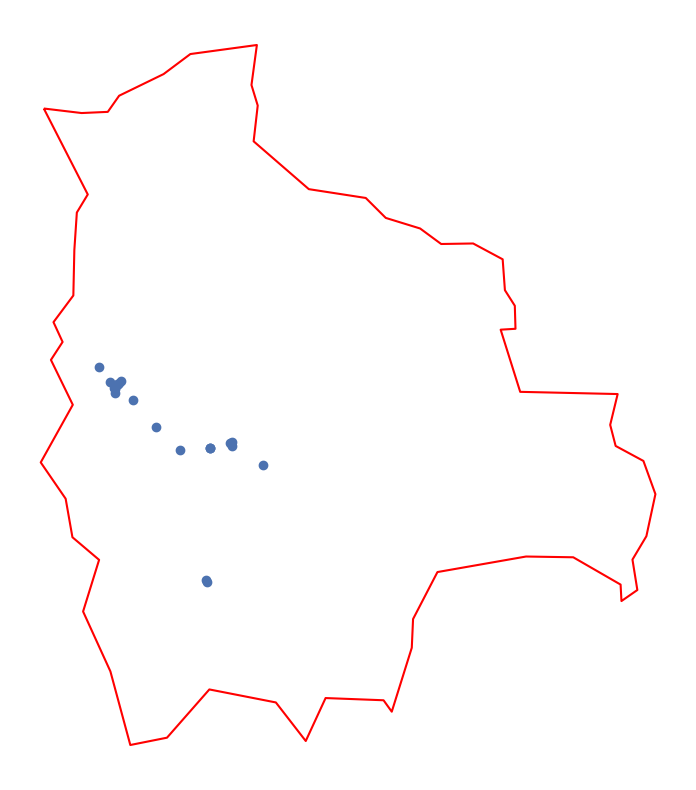

In [91]:
ax = countries.boundary.plot(figsize=(10, 10), color="red")
df_hydro.plot(ax=ax)
plt.axis("off")
image_format = 'png' # e.g .png, .svg, etc.

plt.savefig('hydropower_distribution_map.png', format=image_format, dpi=1200)

(-70.1950263841417,
 -56.893768510553336,
 -23.528465345963966,
 -9.106441257364603)

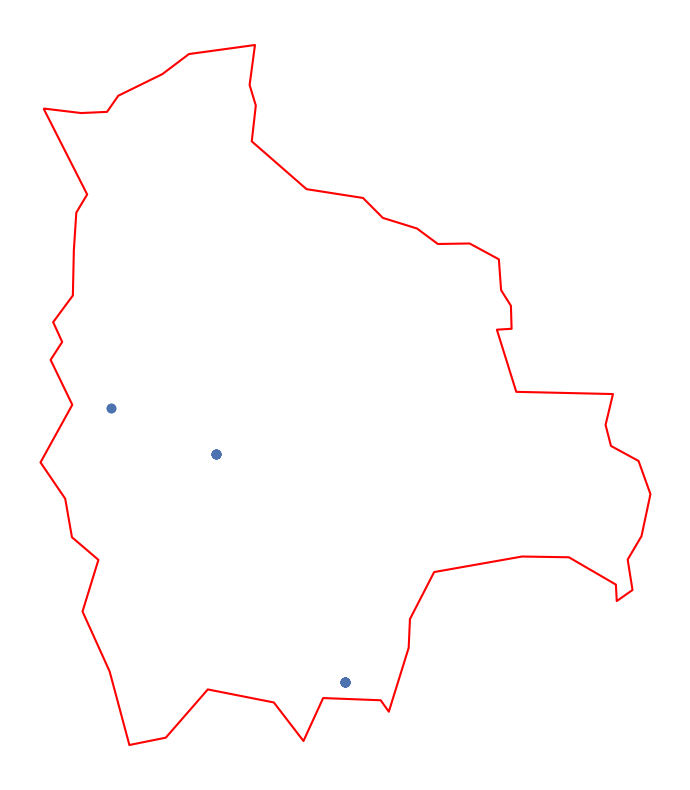

In [37]:
df_gas=df_generators_osm_raw[df_generators_osm_raw['tags.generator:source']=='gas']
ax = countries.boundary.plot(figsize=(10, 10), color="red")
df_gas.plot(ax=ax)
plt.axis("off")

In [38]:
df_gas

,id,tags.power,Type,Country,Area,tags.name,tags.generator:type,tags.generator:method,tags.generator:source,tags.generator:output:electricity,geometry
16,5123436490,generator,Node,BO,NaN,VHE-08,combined_cycle,combustion,gas,10.58 MW,POINT (-66.11669 -17.43058)
17,5123436491,generator,Node,BO,NaN,VHE-07,combined_cycle,combustion,gas,10.58 MW,POINT (-66.11677 -17.43061)
18,5123436492,generator,Node,BO,NaN,VHE-06,combined_cycle,combustion,gas,10.58 MW,POINT (-66.11686 -17.43066)
19,5123436493,generator,Node,BO,NaN,VHE-05,combined_cycle,combustion,gas,10.58 MW,POINT (-66.11695 -17.43069)
20,5123436494,generator,Node,BO,NaN,VHE-01,combined_cycle,combustion,gas,18.52 MW,POINT (-66.11705 -17.43046)
21,5123436495,generator,Node,BO,NaN,VHE-02,combined_cycle,combustion,gas,18.63 MW,POINT (-66.11714 -17.43030)
22,5123436496,generator,Node,BO,NaN,VHE-03,combined_cycle,combustion,gas,18.63 MW,POINT (-66.11721 -17.43014)
23,5123436497,generator,Node,BO,NaN,VHE-04,combined_cycle,combustion,gas,18.63 MW,POINT (-66.11728 -17.42996)
27,6734018736,generator,Node,BO,NaN,NaN,gas_turbine,combustion,gas,NaN,POINT (-63.55894 -21.69469)
28,6734018737,generator,Node,BO,NaN,NaN,gas_turbine,combustion,gas,NaN,POINT (-63.55923 -21.69463)


Powerplants datas

In [39]:

# gadm file imports
countries = shapes
powerplant = gpd.read_file("resources/powerplants.csv")

powerplant[powerplant['Fueltype']=='Hydro']

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

ERROR:fiona._env:Poi

,field_1,Name,Fueltype,Technology,Set,Country,Capacity,Efficiency,Duration,Volume_Mm3,DamHeight_m,StorageCapacity_MWh,DateIn,DateRetrofit,DateOut,lat,lon,EIC,projectID,bus,geometry
1,1,Botijlaca Bolivia,Hydro,,PP,BO,9.441912362255028,,,0.0,0.0,0.0,1938.0,1938.0,2038.0,-16.1925,-68.1405,"{nan, nan, nan}",{'GEO': {'GEO-44740'}},63,None
3,3,Cahua Bolivia,Hydro,,PP,BO,26.722393478080267,,,0.0,0.0,0.0,1974.0,1974.0,2074.0,-16.04561,-67.9939,"{nan, nan}",{'GEO': {'GEO-44748'}},39,None
5,5,Chojlla Bolivia,Hydro,,PP,BO,34.20466365194274,,,0.0,0.0,0.0,2002.0,2002.0,2102.0,-16.4124,-67.7725,{nan},{'GEO': {'GEO-44750'}},28,None
6,6,Chururaqui Bolivia,Hydro,,PP,BO,30.285379275157634,,,0.0,0.0,0.0,1966.0,1966.0,2066.0,-16.105,-68.067,"{nan, nan}",{'GEO': {'GEO-44746'}},40,None
7,7,Corani Bolivia,Hydro,Reservoir,PP,BO,53.31210191082803,,,0.0,0.0,0.0,1992.0,1992.0,2092.0,-17.2122,-65.8758,"{nan, nan, nan, nan}",{'GEO': {'GEO-44721'}},51,None
8,8,Cutichucho Bolivia,Hydro,,PP,BO,23.159407681002897,,,0.0,0.0,0.0,1942.0,1942.0,2042.0,-16.1425,-68.1158,"{nan, nan, nan, nan, nan}",{'GEO': {'GEO-44741'}},40,None
12,12,Harca Bolivia,Hydro,,PP,BO,26.722393478080267,,,0.0,0.0,0.0,1969.0,1969.0,2069.0,-16.07836,-68.03361,"{nan, nan}",{'GEO': {'GEO-44747'}},39,None
13,13,Huaji Bolivia,Hydro,,PP,BO,30.285379275157634,,,0.0,0.0,0.0,1999.0,1999.0,2099.0,-16.0416,-67.9566,"{nan, nan}",{'GEO': {'GEO-44749'}},39,None
16,16,Santa Isabel Bolivia,Hydro,,PP,BO,83.28479300668349,,,0.0,0.0,0.0,1992.0,1992.0,2092.0,-17.1916,-65.8232,"{nan, nan, nan, nan, nan}",{'GEO': {'GEO-44722'}},49,None
17,17,Santa Rosa Bolivia,Hydro,,PP,BO,25.831647028810924,,,0.0,0.0,0.0,1952.0,2003.0,2103.0,-16.129199999999997,-68.103,"{nan, nan, nan}","{'GEO': {'GEO-44742', 'GEO-44743'}}",40,None


- No date in after 2002
- Zongo is without capacity 
- what is Cahua, Chururaqui ???? no found in literature, in miguillas??? serve other countries?? Cahua has a capacity of 2.2 MW and Chururaqui has a capacity of 1.3 MW.???
- Corani is considered as a reservoir, not a run of river

# Map of different energy source

In [41]:
elec_network= os.getcwd() +  "/networks/elec.nc"
n_elec= pypsa.Network(elec_network)

n = n_elec
regions_onshore = gpd.read_file(f"resources/bus_regions/regions_onshore_elec_s_37.geojson")

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers


In [42]:
bus_scale = 5e3 
line_scale = 3e3

In [43]:
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


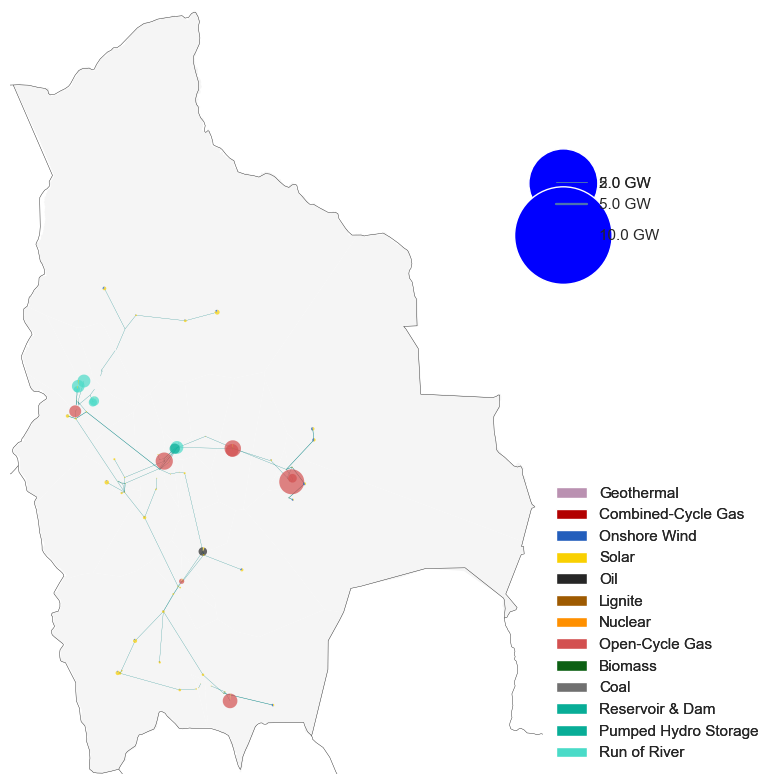

In [44]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
gen = n.generators.groupby(["bus", "carrier"]).p_nom.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom.sum()
buses = pd.concat([gen, sto])

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom / line_scale,
        link_widths=n.links.p_nom / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
# circles legend may requite some fine-tuning
legend_circles_dict = {"bbox_to_anchor": (1, 0.8), "labelspacing": 2.5, **legend_kwargs}
bus_sizes = [5000, 10e3]  # in MW
line_sizes = [2000, 5000]  # in MW
add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,    
)
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
fig.tight_layout()
#fig.savefig("brownfield_capacities_" + country_code + ".png", bbox_inches="tight", dpi=300)